In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
station = session.query(Station).first()
station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2990d8b2470>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [11]:
measurments = session.query(Measurement).first()
measurments.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b636948278>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'date': '2010-01-01'}

In [12]:
first_day = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
#session.query(Measurement.date).(func.strftime("%y %m %d", Measurement.date)).all()


# Exploratory Climate Analysis

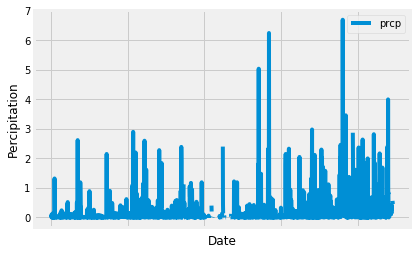

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
rain  = session.query(Measurement.prcp, Measurement.date)
#last_row = session.query(Measurement.date).order_by(Measurement.date.asc()).limit(1).all()
rain.order_by(Measurement.date.desc()).limit(1).all()

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
year_rain = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_rain)
df.set_index('date', inplace=True)
# Sort the dataframe by date
df.sort_values(by = ['date'], ascending  = False)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel('Date')
plt.ylabel('Percipitation')    
plt.show()

![precipitation](Images/precipitation.png)

In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [33]:
from sqlalchemy import func
# Design a query to show how many stations are available in this dataset?
ttl_stations = session.query(Measurement.station).group_by(Measurement.station).count()
ttl_stations

9

In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_stations[0][0]
most_active

session.query(func.max(Measurement.tobs), func.min(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active).filter(Measurement.date > query_date).all()


[(83.0, 59.0, 73.10795454545455)]

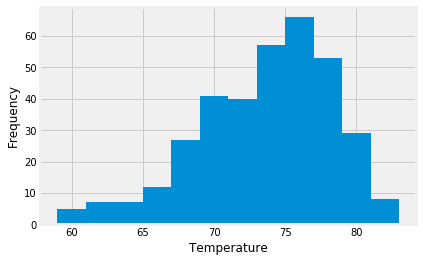

In [54]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).filter(Measurement.date > query_date).group_by(Measurement.date).all()

tobs = pd.DataFrame(year_temp)
tobs.set_index('date', inplace=True)
plt.hist(tobs["tobs"], bins=12)
plt.ylabel('Frequency')    
plt.xlabel('Temperature')    

plt.show()

![precipitation](Images/station-histogram.png)

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-20', '2017-08-20'))

[(58.0, 74.59186410371032, 87.0)]


In [56]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = query_date.strftime("%Y-%m-%d")
end_date = "2017-8-23"

calc_temps(start_date, end_date)


[(58.0, 74.59901654000895, 87.0)]

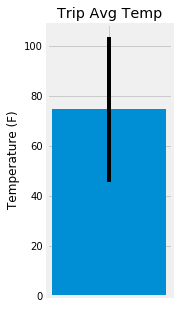

In [57]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = (calc_temps(start_date, end_date))[0][0]
tmax = (calc_temps(start_date, end_date))[0][2]
tavg = (calc_temps(start_date, end_date))[0][1]
plt.figure(figsize=(2,5))
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.bar(1,tavg, yerr= tmax - tmin, tick_label="")
plt.show()


In [58]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#, 
weather_stations = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date >= query_date).filter(Measurement.date <= query_date).group_by(Measurement.prcp).order_by(Measurement.prcp.desc()).all()
print(weather_stations)


[(20.88, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (10.799999999999999, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (8.459999999999997, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (7.200000000000002, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (None, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
